In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Epinet(nn.Module):
    def __init__(self, hid_rep_size, ref_size, hidden_size, output_size, gain, lmbda = 1.0):
        super(Epinet, self).__init__()
        self.ref_size = ref_size
        self.output_size = output_size
        self.gain = gain
        self.lmbda = lmbda

        self.model = nn.Sequential(
            nn.Linear(hid_rep_size + ref_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, ref_size * output_size),
        )

        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=self.gain)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, z, return_full_z=False):
        # stop gradient for x_tilda:
        x = x.detach() # Detach x here to treat sg[phi_zeta(x)] as a constant
        # x has shape (batch_size, num_Z_size, hid_rep_size)
        # z has shape (num_Z_size, ref_size)


        batch_size = x.shape[0]
        num_Z_size = x.shape[1]
        assert num_Z_size == z.shape[0], "wrong z dimension"
        # repeat z at 0th dimension to match batch_size
        z = z.unsqueeze(0).repeat(batch_size, 1, 1)

        x_tilda = torch.cat((x, z), dim=2)
        
        x_tilda = self.model(x_tilda)
        # Reshape the output to (batch_size, ref_size, output_size)
        x_tilda = x_tilda.view(batch_size, num_Z_size, self.ref_size, self.output_size)

        # xtilda transpose @ z
        x_tilda = torch.transpose(x_tilda, 2, 3) @ z.unsqueeze(3)
        if return_full_z:
            return self.lmbda * x_tilda.squeeze()
        else:
            x_tilda = torch.mean(x_tilda, dim=1)
            x_tilda = x_tilda.view(-1, self.output_size)
            return self.lmbda * x_tilda
        
class toy_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, enn_dim, ref_size, lmbda):
        super(toy_model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            
        )
        self.head = nn.Linear(hidden_dim, output_dim)
        self.eta = Epinet(hidden_dim, ref_size, enn_dim, output_dim, 1.0, lmbda)
        self.p = Epinet(hidden_dim, ref_size, enn_dim, output_dim, 1.0, lmbda)

        for param in self.p.model.parameters():
            param.requires_grad = False

    def forward(self, x, z, return_full_z=False):
        hid_rep = self.model(x)

        num_Z_size = z.shape[0]
        z_hid_rep = hid_rep.unsqueeze(1).repeat(1, num_Z_size, 1)

        p = self.p(z_hid_rep, z, return_full_z)
        eta = self.eta(z_hid_rep, z, return_full_z)
        model = self.head(z_hid_rep).squeeze()
        if return_full_z == True:
            reward = p+eta+model
            return p, eta, model, reward
        else:
            model = torch.mean(model, dim=1).view(-1, self.output_dim)
            reward = p+eta+model
            return p, eta, model, reward

class vanilla(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(vanilla, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.head = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        hid_rep = self.model(x)
        model = self.head(hid_rep).squeeze()
        return model

In [27]:
import numpy as np

a = 0
b = 10 
num_train = 100000
num_eval = 1000
num_joint = 500
N = 100
noise_dim = 10
noise_a = 1
noise_b = 1.5

train_dataset = []
eval_dataset = []
joint_dataset = []

for _ in range(num_train):
    
    sample = np.random.normal(a, np.sqrt(b), N)
    
    preferred_value =  np.random.normal(np.mean(sample), noise_a, noise_dim)
    non_preferred_value =  np.random.normal(np.mean(sample), noise_b, noise_dim)
    
    train_dataset.append({
        'input': torch.tensor(sample, dtype=torch.float32),
        'preferred': torch.tensor(preferred_value, dtype=torch.float32),
        'non_preferred': torch.tensor(non_preferred_value, dtype=torch.float32)
    })

for _ in range(num_eval):
    
    sample = np.random.normal(a, np.sqrt(b), N)
    
    preferred_value =  np.random.normal(np.mean(sample), noise_a, noise_dim)
    non_preferred_value =  np.random.normal(np.mean(sample), noise_b, noise_dim)
    
    eval_dataset.append({
        'input': torch.tensor(sample, dtype=torch.float32),
        'preferred': torch.tensor(preferred_value, dtype=torch.float32),
        'non_preferred': torch.tensor(non_preferred_value, dtype=torch.float32)
    })

for _ in range(num_joint):
    
    joint_data = []
    A_sample = np.random.normal(a, np.sqrt(b), N)
    B_sample = np.random.normal(a, np.sqrt(b), N)
    preferred_A = np.random.normal(np.mean(A_sample), noise_a, noise_dim)
    preferred_B = np.random.normal(np.mean(B_sample), noise_a, noise_dim)
    non_preferred_A = np.random.normal(np.mean(A_sample), noise_b, noise_dim)
    non_preferred_B = np.random.normal(np.mean(B_sample), noise_b, noise_dim)
    for _ in range(10):
        if np.random.rand() > 0.5:
            sample = A_sample
            preferred_value = preferred_A
            non_preferred_value = non_preferred_A
        else:
            sample = B_sample
            preferred_value = preferred_B
            non_preferred_value = non_preferred_B

        joint_data.append({
            'input': torch.tensor(sample, dtype=torch.float32),
            'preferred': torch.tensor(preferred_value, dtype=torch.float32),
            'non_preferred': torch.tensor(non_preferred_value, dtype=torch.float32)
        })

    joint_dataset.append({
        'joint_data': joint_data
    })

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=1000, shuffle=True)
joint_dataloader = torch.utils.data.DataLoader(joint_dataset, batch_size=1, shuffle=True)

In [30]:
input_dim = N
hidden_dim = 128
output_dim = 1
enn_dim = 64
ref_size = 10
num_ref = 1000

In [31]:
new_toymodel = toy_model(input_dim + noise_dim, hidden_dim, output_dim, enn_dim, ref_size, 1.0)
vanilla_model = vanilla(input_dim + noise_dim, hidden_dim, output_dim)

optimzer = torch.optim.AdamW(new_toymodel.parameters(), lr=1e-3, weight_decay=0.1)
v_optimizer = torch.optim.AdamW(vanilla_model.parameters(), lr=1e-3, weight_decay=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_toymodel.to(device)
vanilla_model.to(device)

vanilla(
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
  )
  (head): Linear(in_features=128, out_features=1, bias=True)
)

In [32]:
accuracy_graph = []
joint_likelihood_graph = []
log_joint_likelihood_graph = []
joint_log_loss_graph = []
eval_loss_graph = []
for e in range(1):
    print("epoch: ", e)
    for i, batch in enumerate(train_dataloader):
        optimzer.zero_grad()
        input, preferred, non_preferred = batch['input'], batch['preferred'], batch['non_preferred']
        prefered_x = torch.cat((input, preferred), dim=1)
        non_prefered_x = torch.cat((input, non_preferred), dim=1)
        z = torch.randn(num_ref, ref_size)
        prefered_x = prefered_x.to(device)
        non_prefered_x = non_prefered_x.to(device)
        z = z.to(device)
        p_win, eta_win, model_win, reward_win = new_toymodel(x = prefered_x, z = z, return_full_z=False)
        p_lose, eta_lose, model_lose, reward_lose = new_toymodel(x = non_prefered_x, z = z, return_full_z=False)
        loss = -torch.mean(torch.log(torch.sigmoid(reward_win - reward_lose)))
        loss.backward()
        optimzer.step()

        if i % 100 == 0:
            # evaluation:
            eval_sum = 0
            eval_loss_total = 0
            for _, eval_batch in enumerate(eval_dataloader):
                eval_input, eval_preferred, eval_non_preferred = eval_batch['input'], eval_batch['preferred'], eval_batch['non_preferred']
                eval_prefered_x = torch.cat((eval_input, eval_preferred), dim=1)
                eval_non_prefered_x = torch.cat((eval_input, eval_non_preferred), dim=1)
                z = torch.randn(num_ref, ref_size)
                eval_prefered_x = eval_prefered_x.to(device)
                eval_non_prefered_x = eval_non_prefered_x.to(device)
                z = z.to(device)
                eval_p_win, eval_eta_win, eval_model_win, eval_reward_win = new_toymodel(x = eval_prefered_x, z = z, return_full_z=False)
                eval_p_lose, eval_eta_lose, eval_model_lose, eval_reward_lose = new_toymodel(x = eval_non_prefered_x, z = z, return_full_z=False)
                eval_loss = -torch.mean(torch.log(torch.sigmoid(eval_reward_win - eval_reward_lose)))
                # count the number of eval_reward_win > eval_reward_lose
                count = torch.sum(eval_reward_win > eval_reward_lose).item()
                eval_sum += count
                eval_loss_total += eval_loss.item()
            eval_loss_graph.append(eval_loss_total / num_eval)
            accuracy = eval_sum / (num_eval)    
            accuracy_graph.append(accuracy)
                #print("eval loss: ", eval_loss.item(), "eval_sum: ", eval_sum)

            joint_likelihood = 0
            log_j = 0
            joint_log_loss = 0
            for _,joint_batch in enumerate(joint_dataloader):
                joint_data = joint_batch['joint_data']
                prod = []
                z = torch.randn(num_ref, ref_size)
                z = z.to(device)
                for i in range(len(joint_data)):
                    
                    input = joint_data[i]['input']
                    preferred = joint_data[i]['preferred']
                    non_preferred = joint_data[i]['non_preferred']
                    prefered_x = torch.cat((input, preferred), dim=1)
                    non_prefered_x = torch.cat((input, non_preferred), dim=1)
                    prefered_x = prefered_x.to(device)
                    non_prefered_x = non_prefered_x.to(device)
                    p_win, eta_win, model_win, reward_win = new_toymodel(x = prefered_x, z = z, return_full_z=True)
                    p_lose, eta_lose, model_lose, reward_lose = new_toymodel(x = non_prefered_x, z = z, return_full_z=True)
                    reward_diff = torch.mean(reward_win - reward_lose)
                    log_loss = -torch.mean(torch.log(torch.sigmoid(reward_diff)))
                    reward_tensor = torch.cat((reward_win.unsqueeze(-1), reward_lose.unsqueeze(-1)), dim=1)
                    softmax_tensor = torch.softmax(reward_tensor, dim=1)[:,0]
                    log_softmax_tensor = torch.log(softmax_tensor)
                    joint_log_likelihood = torch.mean(log_softmax_tensor)

                    joint_likelihood += joint_log_likelihood
                    joint_log_loss += log_loss
                    prod.append(softmax_tensor)

                prod = torch.stack(prod).squeeze()
                product_softmax_values = torch.prod(prod, dim=0)
                avg_softmax_values = torch.mean(product_softmax_values)
                log_joint_likelihood = torch.log(avg_softmax_values)
                log_j += log_joint_likelihood
            
            joint_likelihood_graph.append(joint_likelihood.item())
            log_joint_likelihood_graph.append(log_j.item())
            joint_log_loss_graph.append(joint_log_loss.item())
            print("eval_loss: ", eval_loss_total, "accuracy: ", accuracy, "joint_log_loss: ",joint_log_loss.item(), "joint_likelihood: ", joint_likelihood.item(), "log_joint_likelihood: ", log_j.item())


epoch:  0
eval_loss:  0.6931523084640503 accuracy:  0.506 joint_log_loss:  3465.48388671875 joint_likelihood:  -3465.692626953125 log_joint_likelihood:  -3464.53173828125


In [ ]:
v_loss_graph = []
v_accuracy_graph = []
v_joint_likelihood_graph = []
v_log_joint_likelihood_graph = []
v_eval_loss_graph = []
v_joint_log_loss_graph = []
for e in range(1):
    print("epoch: ", e)
    for i, batch in enumerate(train_dataloader):
        v_optimizer.zero_grad()
        input, preferred, non_preferred = batch['input'], batch['preferred'], batch['non_preferred']
        prefered_x = torch.cat((input, preferred), dim=1)
        non_prefered_x = torch.cat((input, non_preferred), dim=1)
        prefered_x = prefered_x.to(device)
        non_prefered_x = non_prefered_x.to(device)
        reward_win = vanilla_model(x = prefered_x)
        reward_lose = vanilla_model(x = non_prefered_x)
        loss = -torch.mean(torch.log(torch.sigmoid(reward_win - reward_lose)))
        loss.backward()
        v_loss_graph.append(loss.item())
        v_optimizer.step()

        # evaluation:
        if i % 100 == 0:
            eval_sum = 0
            eval_loss_total = 0
            for _, eval_batch in enumerate(eval_dataloader):
                eval_input, eval_preferred, eval_non_preferred = eval_batch['input'], eval_batch['preferred'], eval_batch['non_preferred']
                eval_prefered_x = torch.cat((eval_input, eval_preferred), dim=1)
                eval_non_prefered_x = torch.cat((eval_input, eval_non_preferred), dim=1)
                eval_prefered_x = eval_prefered_x.to(device)
                eval_non_prefered_x = eval_non_prefered_x.to(device)
                eval_reward_win = vanilla_model(x = eval_prefered_x)
                eval_reward_lose = vanilla_model(x = eval_non_prefered_x)
                eval_loss = -torch.mean(torch.log(torch.sigmoid(eval_reward_win - eval_reward_lose)))
                # count the number of eval_reward_win > eval_reward_lose
                count = torch.sum(eval_reward_win > eval_reward_lose).item()
                eval_sum += count
                eval_loss_total += eval_loss.item()
            v_eval_loss_graph.append(eval_loss_total / num_eval)
            accuracy = eval_sum / (num_eval)  
            v_accuracy_graph.append(accuracy)  
            
                #print("eval loss: ", eval_loss.item(), "eval_sum: ", eval_sum)

            joint_likelihood = 0
            log_j = 0
            joint_log_loss = 0
            for _,joint_batch in enumerate(joint_dataloader):
                joint_data = joint_batch['joint_data']
                prod = []
                for i in range(len(joint_data)):
                    input = joint_data[i]['input']
                    preferred = joint_data[i]['preferred']
                    non_preferred = joint_data[i]['non_preferred']
                    prefered_x = torch.cat((input, preferred), dim=1)
                    non_prefered_x = torch.cat((input, non_preferred), dim=1)
                    prefered_x = prefered_x.to(device)
                    non_prefered_x = non_prefered_x.to(device)
                    reward_win = vanilla_model(x = prefered_x)
                    reward_lose = vanilla_model(x = non_prefered_x)
                    reward_diff = torch.mean(reward_win - reward_lose)
                    log_loss = -torch.mean(torch.log(torch.sigmoid(reward_diff)))
                    reward_tensor = torch.cat((reward_win.unsqueeze(-1), reward_lose.unsqueeze(-1)), dim=0)
                    softmax_tensor = torch.softmax(reward_tensor, dim=0)[0]
                    log_softmax_tensor = torch.log(softmax_tensor)
                    joint_log_likelihood = torch.mean(log_softmax_tensor)
                    prod.append(softmax_tensor)

                    joint_likelihood += joint_log_likelihood
                    joint_log_loss += log_loss

                prod = torch.stack(prod).squeeze()
                product_softmax_values = torch.prod(prod, dim=0)
                avg_softmax_values = torch.mean(product_softmax_values)
                log_joint_likelihood = torch.log(avg_softmax_values)
                log_j += log_joint_likelihood

            v_joint_likelihood_graph.append(joint_likelihood.item())
            v_log_joint_likelihood_graph.append(log_j.item())
            v_joint_log_loss_graph.append(joint_log_loss.item())
            print("eval_loss: ", eval_loss_total, "accuracy: ", accuracy, "joint log loss: ", joint_log_loss, "joint_likelihood: ", joint_likelihood.item(), "log_joint_likelihood: ", log_j.item())


epoch:  0
eval_loss:  1.3861733078956604 accuracy:  0.5095 joint_likelihood:  -6930.65966796875 log_joint_likelihood:  -6930.666015625
eval_loss:  0.9237056970596313 accuracy:  0.7685 joint_likelihood:  -4714.78759765625 log_joint_likelihood:  -4714.7685546875


eval_loss:  0.7517935931682587 accuracy:  0.8295 joint_likelihood:  -3362.21630859375 log_joint_likelihood:  -3362.20849609375
eval_loss:  0.7098710536956787 accuracy:  0.838 joint_likelihood:  -3190.993896484375 log_joint_likelihood:  -3190.99462890625
eval_loss:  0.6484470665454865 accuracy:  0.852 joint_likelihood:  -3181.781005859375 log_joint_likelihood:  -3181.770263671875
eval_loss:  0.6399187445640564 accuracy:  0.8635 joint_likelihood:  -2926.48388671875 log_joint_likelihood:  -2926.48779296875
eval_loss:  0.6393686234951019 accuracy:  0.852 joint_likelihood:  -2956.99853515625 log_joint_likelihood:  -2957.01416015625
eval_loss:  0.6093670725822449 accuracy:  0.867 joint_likelihood:  -2854.772216796875 log_joint_likelihood:  -2854.77734375
eval_loss:  0.6015426516532898 accuracy:  0.864 joint_likelihood:  -2854.818603515625 log_joint_likelihood:  -2854.825439453125
eval_loss:  0.618393748998642 accuracy:  0.8585 joint_likelihood:  -2833.2470703125 log_joint_likelihood:  -2833.

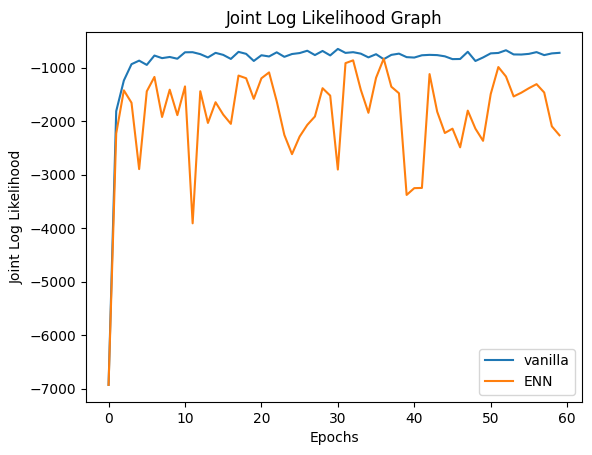

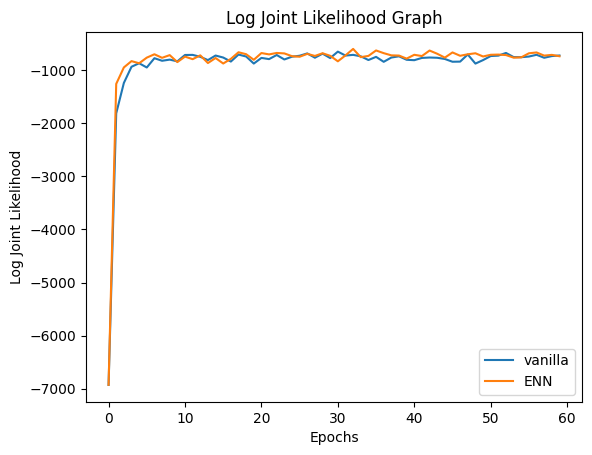

In [12]:
import matplotlib.pyplot as plt
# Plotting Joint Likelihood Graph
plt.figure()
plt.plot(v_joint_likelihood_graph, label="vanilla")
plt.plot(joint_likelihood_graph, label="ENN")
plt.title("Joint Log Likelihood Graph")
plt.xlabel("Epochs")
plt.ylabel("Joint Log Likelihood")
plt.legend()
plt.show()




plt.figure()
plt.plot(v_log_joint_likelihood_graph, label="vanilla")
plt.plot(log_joint_likelihood_graph, label="ENN")
plt.title("Log Joint Likelihood Graph")
plt.xlabel("Epochs")
plt.ylabel("Log Joint Likelihood")
plt.legend()
plt.show()



In [17]:
new_toymodel = toy_model(input_dim, hidden_dim, output_dim, enn_dim, ref_size, 1.0)
vanilla_model = vanilla(input_dim, hidden_dim, output_dim)

optimzer = torch.optim.AdamW(new_toymodel.parameters(), lr=3e-4, weight_decay=0.1)
v_optimizer = torch.optim.AdamW(vanilla_model.parameters(), lr=3e-4, weight_decay=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_toymodel.to(device)
vanilla_model.to(device)

vanilla(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
  )
  (head): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
import numpy as np

a = 0
b = 5
num_train = 300000
num_eval = 1000
num_joint = 500
N = 100

train_dataset = []
eval_dataset = []
joint_dataset = []

for _ in range(num_train):
    

    if torch.rand(1) > 0.5:
        sample = np.random.normal(1, np.sqrt(b), N)
        preferred_value = 1
        non_preferred_value = 1
    else:
        sample = np.random.normal(-1, np.sqrt(b), N)
        preferred_value = 0
        non_preferred_value = 0
    
    train_dataset.append({
        'input': torch.tensor(sample, dtype=torch.float32),
        'preferred': torch.tensor(preferred_value, dtype=torch.float32),
        'non_preferred': torch.tensor(non_preferred_value, dtype=torch.float32)
    })

for _ in range(num_eval):
    
    if torch.rand(1) > 0.5:
        sample = np.random.normal(1, np.sqrt(b), N)
        preferred_value = 1
        non_preferred_value = 1
    else:
        sample = np.random.normal(-1, np.sqrt(b), N)
        preferred_value = 0
        non_preferred_value = 0
    
    eval_dataset.append({
        'input': torch.tensor(sample, dtype=torch.float32),
        'preferred': torch.tensor(preferred_value, dtype=torch.float32),
        'non_preferred': torch.tensor(non_preferred_value, dtype=torch.float32)
    })

for _ in range(num_joint):
    
    joint_data = []
    if torch.rand(1) > 0.5:
        A_sample = np.random.normal(1, np.sqrt(b), N)
        preferred_A = 1
        non_preferred_A = 1
    else:
        A_sample = np.random.normal(-1, np.sqrt(b), N)
        preferred_A = 0
        non_preferred_A = 0

    if torch.rand(1) > 0.5:
        B_sample = np.random.normal(1, np.sqrt(b), N)
        preferred_B = 1
        non_preferred_B = 1
    else:
        B_sample = np.random.normal(-1, np.sqrt(b), N)
        preferred_B = 0
        non_preferred_B = 0
    for _ in range(10):
        if np.random.rand() > 0.5:
            sample = A_sample
            preferred_value = preferred_A
            non_preferred_value = non_preferred_A
        else:
            sample = B_sample
            preferred_value = preferred_B
            non_preferred_value = non_preferred_B

        joint_data.append({
            'input': torch.tensor(sample, dtype=torch.float32),
            'preferred': torch.tensor(preferred_value, dtype=torch.float32),
            'non_preferred': torch.tensor(non_preferred_value, dtype=torch.float32)
        })

    joint_dataset.append({
        'joint_data': joint_data
    })

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=1000, shuffle=True)
joint_dataloader = torch.utils.data.DataLoader(joint_dataset, batch_size=1, shuffle=True)

In [19]:
accuracy_graph = []
joint_likelihood_graph = []
log_joint_likelihood_graph = []
eval_loss_graph = []
for e in range(5):
    for i, batch in enumerate(train_dataloader):
        optimzer.zero_grad()
        input, preferred, non_preferred = batch['input'], batch['preferred'], batch['non_preferred']
        preferred = preferred.unsqueeze(-1).to(device)
        prefered_x = input
        z = torch.randn(num_ref, ref_size)
        prefered_x = prefered_x.to(device)
        z = z.to(device)
        p_win, eta_win, model_win, reward_win = new_toymodel(x = prefered_x, z = z, return_full_z=False)
        # binary cross entropy loss with logits , logits = reward_win
        loss = F.binary_cross_entropy_with_logits(reward_win, preferred)
        loss.backward()
        optimzer.step()



        if i % 100 == 0:
            # evaluation:
            eval_sum = 0
            eval_loss_total = 0
            for _, eval_batch in enumerate(eval_dataloader):
                eval_input, eval_preferred, eval_non_preferred = eval_batch['input'], eval_batch['preferred'], eval_batch['non_preferred']
                eval_prefered_x = eval_input
                eval_prefered = eval_preferred.unsqueeze(-1).to(device)
                z = torch.randn(num_ref, ref_size)
                eval_prefered_x = eval_prefered_x.to(device)
                z = z.to(device)
                eval_p_win, eval_eta_win, eval_model_win, eval_reward_win = new_toymodel(x = eval_prefered_x, z = z, return_full_z=False)
                eval_loss =  F.binary_cross_entropy_with_logits(eval_reward_win, eval_prefered)
                # count the number of sigmoid logits > 0.5 while preferred = 1 and sigmoid logits < 0.5 while preferred = 0
                prob = torch.sigmoid(eval_reward_win)
                predictions = (prob > 0.5).float()
                correct_predictions = (predictions == eval_prefered).float()
                count = torch.sum(correct_predictions).item()
                eval_sum += count
                eval_loss_total += eval_loss.item()
            eval_loss_graph.append(eval_loss_total / num_eval)
            accuracy = eval_sum / (num_eval)    
            accuracy_graph.append(accuracy)
                #print("eval loss: ", eval_loss.item(), "eval_sum: ", eval_sum)

            joint_likelihood = 0
            log_j = 0
            for _,joint_batch in enumerate(joint_dataloader):
                joint_data = joint_batch['joint_data']
                prod = []
                z = torch.randn(num_ref, ref_size)
                z = z.to(device)
                for i in range(len(joint_data)):
                    input = joint_data[i]['input']
                    preferred = joint_data[i]['preferred']
                    preferred = preferred.unsqueeze(-1).to(device)
                    prefered_x = input
                    prefered_x = prefered_x.to(device)
                    p_win, eta_win, model_win, reward_win = new_toymodel(x = prefered_x, z = z, return_full_z=True)

                    sigmoid_values = torch.sigmoid(reward_win)
                    likelihood_list = torch.where(preferred.unsqueeze(-1) == 1, sigmoid_values, 1 - sigmoid_values)
                    likelihood_list = torch.clamp(likelihood_list, min=1e-5)
                    log_softmax_values = torch.log(likelihood_list)
                    log_softmax_values = torch.mean(log_softmax_values, dim=-1).squeeze()

                    # create a product of all the likelihood_list, we need to store them fist in a tensor
                    prod.append(likelihood_list)
                    joint_likelihood += log_softmax_values

                prod = torch.stack(prod).squeeze()
                product_softmax_values = torch.prod(prod, dim=0)
                avg_softmax_values = torch.mean(product_softmax_values)
                log_joint_likelihood = torch.log(avg_softmax_values)
                log_j += log_joint_likelihood
            log_joint_likelihood_graph.append(log_joint_likelihood.item())
            joint_likelihood_graph.append(log_j.item())
            print("eval_loss: ", eval_loss.item(), "accuracy: ", accuracy, "joint_likelihood: ", joint_likelihood.item(), "log_joint_likelihood: ", log_j.item())

eval_loss:  0.6934331655502319 accuracy:  0.51 joint_likelihood:  -4312.44921875 log_joint_likelihood:  -2526.087646484375
eval_loss:  0.0002322397631360218 accuracy:  1.0 joint_likelihood:  -4409.51904296875 log_joint_likelihood:  -209.3056640625
eval_loss:  0.00010914933227468282 accuracy:  1.0 joint_likelihood:  -4489.1376953125 log_joint_likelihood:  -201.01795959472656
eval_loss:  6.016735642333515e-05 accuracy:  1.0 joint_likelihood:  -4470.25 log_joint_likelihood:  -192.67218017578125
eval_loss:  0.00029757042648270726 accuracy:  1.0 joint_likelihood:  -4615.29248046875 log_joint_likelihood:  -194.713134765625
eval_loss:  2.398837386863306e-05 accuracy:  1.0 joint_likelihood:  -4475.2353515625 log_joint_likelihood:  -182.5299835205078
eval_loss:  4.210586121189408e-05 accuracy:  1.0 joint_likelihood:  -4363.7158203125 log_joint_likelihood:  -178.19500732421875
eval_loss:  1.7520205801702105e-05 accuracy:  1.0 joint_likelihood:  -4389.91748046875 log_joint_likelihood:  -173.59375

KeyboardInterrupt: 

In [24]:
accuracy_graph = []
joint_likelihood_graph = []
log_joint_likelihood_graph = []
eval_loss_graph = []
for e in range(5):
    for i, batch in enumerate(train_dataloader):
        optimzer.zero_grad()
        input, preferred, non_preferred = batch['input'], batch['preferred'], batch['non_preferred']
        preferred = preferred.unsqueeze(-1).to(device)
        prefered_x = input
        prefered_x = prefered_x.to(device)
        reward_win = vanilla_model(x = prefered_x)
        # binary cross entropy loss with logits , logits = reward_win
        loss = F.binary_cross_entropy_with_logits(reward_win, preferred)
        loss.backward()
        optimzer.step()



        if i % 100 == 0:
            # evaluation:
            eval_sum = 0
            eval_loss_total = 0
            for _, eval_batch in enumerate(eval_dataloader):
                eval_input, eval_preferred, eval_non_preferred = eval_batch['input'], eval_batch['preferred'], eval_batch['non_preferred']
                eval_prefered_x = eval_input
                eval_prefered = eval_preferred.unsqueeze(-1).to(device)
                eval_prefered_x = eval_prefered_x.to(device)
                eval_reward_win = vanilla_model(x = prefered_x)
                eval_loss =  F.binary_cross_entropy_with_logits(eval_reward_win, eval_prefered)
                # count the number of sigmoid logits > 0.5 while preferred = 1 and sigmoid logits < 0.5 while preferred = 0
                prob = torch.sigmoid(eval_reward_win)
                predictions = (prob > 0.5).float()
                correct_predictions = (predictions == eval_prefered).float()
                count = torch.sum(correct_predictions).item()
                eval_sum += count
                eval_loss_total += eval_loss.item()
            eval_loss_graph.append(eval_loss_total / num_eval)
            accuracy = eval_sum / (num_eval)    
            accuracy_graph.append(accuracy)
                #print("eval loss: ", eval_loss.item(), "eval_sum: ", eval_sum)

            joint_likelihood = 0
            log_j = 0
            for _,joint_batch in enumerate(joint_dataloader):
                joint_data = joint_batch['joint_data']
                prod = []
                for i in range(len(joint_data)):
                    input = joint_data[i]['input']
                    preferred = joint_data[i]['preferred']
                    preferred = preferred.unsqueeze(-1).to(device)
                    prefered_x = input
                    prefered_x = prefered_x.to(device)
                    reward_win = vanilla_model(x = prefered_x)

                    sigmoid_values = torch.sigmoid(reward_win)
                    likelihood_list = torch.where(preferred.unsqueeze(-1) == 1, sigmoid_values, 1 - sigmoid_values)
                    likelihood_list = torch.clamp(likelihood_list, min=1e-5)
                    log_softmax_values = torch.log(likelihood_list)
                    log_softmax_values = torch.mean(log_softmax_values, dim=-1).squeeze()

                    # create a product of all the likelihood_list, we need to store them fist in a tensor
                    prod.append(likelihood_list)
                    joint_likelihood += log_softmax_values

                prod = torch.stack(prod).squeeze()
                product_softmax_values = torch.prod(prod, dim=0)
                avg_softmax_values = torch.mean(product_softmax_values)
                log_joint_likelihood = torch.log(avg_softmax_values)
                log_j += log_joint_likelihood
            log_joint_likelihood_graph.append(log_joint_likelihood.item())
            joint_likelihood_graph.append(log_j.item())
            print("eval_loss: ", eval_loss.item(), "accuracy: ", accuracy, "joint_likelihood: ", joint_likelihood.item(), "log_joint_likelihood: ", log_j.item())

eval_loss:  tensor(6.4900e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) accuracy:  1.0 joint_likelihood:  -5533.115234375 log_joint_likelihood:  -845.58447265625
eval_loss:  tensor(1.3004e-05, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) accuracy:  1.0 joint_likelihood:  -5176.15673828125 log_joint_likelihood:  -825.0386962890625
eval_loss:  tensor(6.7171e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) accuracy:  1.0 joint_likelihood:  -5172.6826171875 log_joint_likelihood:  -820.7219848632812
eval_loss:  tensor(6.5463e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) accuracy:  1.0 joint_likelihood:  -5188.52783203125 log_joint_likelihood:  -818.2296142578125
eval_loss:  tensor(9.5616e-06, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) accuracy:  1.0 joint_likelihood:  -5193.16650390625 log_joint_likelihood:  -815.135986328125
eval_loss:  tens

KeyboardInterrupt: 